| Name     | ID   |
|----------|------|
| Zyad samy ramadan    | 19015720  |
| Ahmed Mahmoud Abdelhay Elemary     | 19015359  |
| Gamal Abdel Hameed Nasef Nowesar     | 19015550  |

# Imports

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math

# Methods

## Smoothing the image

In [ ]:
def smooth(image, size):
    return cv2.medianBlur(image, size)

## Edge Detection

In [ ]:
def detect_edges(image, threshold1, threshold2):
    return cv2.Canny(image, threshold1, threshold2)

## Region Of Interest

In [ ]:
def mask(image, vertices, color=255):
    vertices = np.array([vertices], dtype=np.int32)
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, vertices, color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

## Accumulation into (ρ, θ)-space using Hough transform

In [ ]:
def hough(image):
    height, width = image.shape
    max_theta = 180
    max_rho = int(np.sqrt(width ** 2 + height ** 2))
    accumulator = np.zeros((2 * max_rho, max_theta + 1), dtype=np.int32)

    for x in range(width):
      for y in range(height):
        if image[y,x] != 0:
            for theta in range(max_theta + 1):
                theta_rad = math.radians(theta)
                rho = int(x * math.cos(theta_rad) + y * math.sin(theta_rad)) + max_rho
                accumulator[rho,theta] += 1

    return accumulator

## non_max_suppresion

In [ ]:
def non_max_suppresion(accumulator, threshold = 100):
  local_maxima = []
  max_rho = accumulator.shape[0] / 2
  d = 20

  for rho in range(1, accumulator.shape[0] - 1):
      for theta in range(1, accumulator.shape[1] - 1):
        if accumulator[rho, theta] > threshold:
          is_maximum = True
          for dr in range(-d,d+1):
              for dtheta in range(-d,d+1):
                  if accumulator[rho, theta] < accumulator[rho + dr, theta + dtheta]:
                      is_maximum = False
                      break
              if not is_maximum:
                  break
          if is_maximum:
              local_maxima.append((rho - max_rho, math.radians(theta)))
  return local_maxima

## Convert lines from polar coordinates to Cartesian coordinates

In [ ]:
def line_points(lines, f=2000):
    points = []
    for line in lines:
      rho, theta = line
      cos_theta = np.cos(theta)
      sin_theta= np.sin(theta)
      x0 = rho * cos_theta
      y0 = rho * sin_theta
      x1 = int(x0 + f * (-sin_theta))
      y1 = int(y0 + f * (cos_theta))
      x2 = int(x0 - f * (-sin_theta))
      y2 = int(y0 - f * (cos_theta))
      points.append([x1,y1,x2,y2])
    return points

## Draw lines on an image

In [ ]:
def line_image(image, lines, color, thickness=2):
    line_image = np.zeros_like(image)
    for line in lines:
        x1, y1, x2, y2 = line
        cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)
    return line_image

## Overlay lines on an image

In [ ]:
def image_with_lines(image, lines):
  return cv2.addWeighted(image, 0.8, lines, 1, 0)

## Display an image using matplotlib

In [ ]:
def show_image(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.show()

# Main

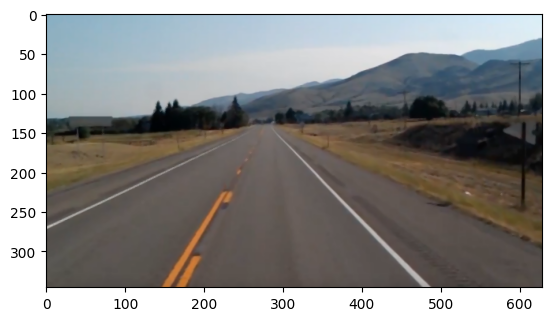

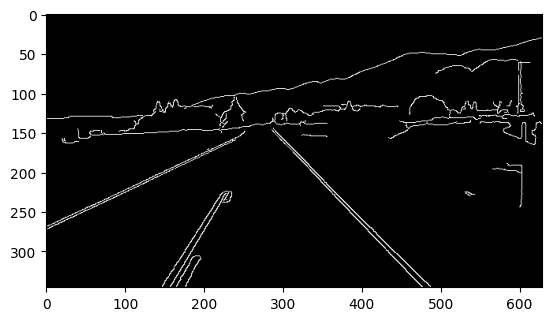

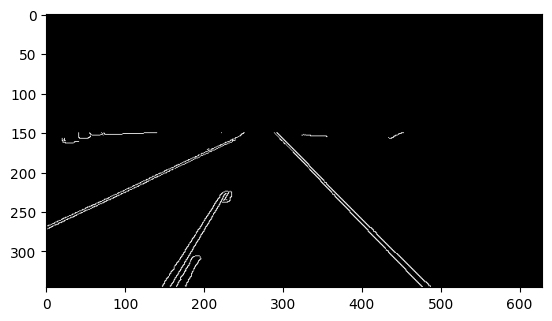

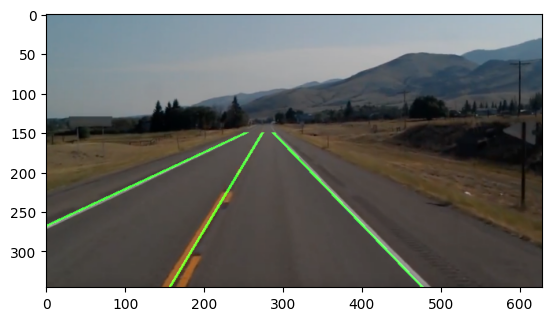

In [ ]:
line_color = (0, 255, 0)
smooth_filter_sz = 3
mask_vertices = [(0,700), (0,320), (1000,320),(1000,700)]
mask_vertices = [(0,350), (0,150), (500,150),(500,350)]


# 1. Smoothing the image
image = cv2.imread('road.jpg')
smoothed_image = smooth(image, smooth_filter_sz)
show_image(smoothed_image)

# 2. Edge Detection
edges = detect_edges(image=smoothed_image, threshold1=50, threshold2=250)
show_image(edges)


# 3. Region Of Interest
masked_edges = mask(edges, mask_vertices)
show_image(masked_edges)


# Accumulation into (ρ, θ)-space using Hough transform
accumulator = hough(masked_edges)


# Refining Coordinates and HT Post-Processing:
# apply non_max_suppresion
max_lines = non_max_suppresion(accumulator)
# Convert lines from polar coordinates to Cartesian coordinates
points = line_points(max_lines)
# Draw lines on an image
lines_img = line_image(image, points, line_color)
# apply the mask on the image
masked_lines = mask(lines_img, mask_vertices, line_color)
# Overlay lines on an image
out_img = image_with_lines(image, masked_lines)
# show the output image
show_image(out_img)

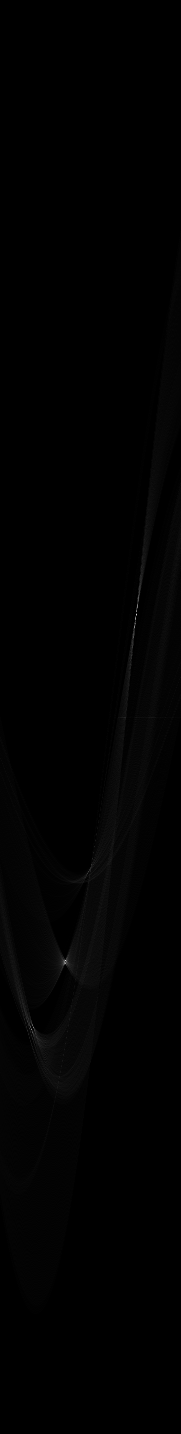

In [ ]:
# Plot the accumulator array as an image
cv2_imshow(accumulator)

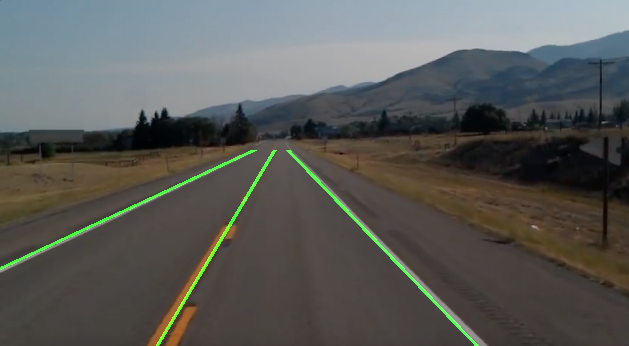

In [ ]:
# show the output image
cv2_imshow(out_img)